In [1]:
from torch_snippets import *
import torchvision
from torchvision import transforms
import torchvision.utils as vutils
import cv2, numpy as np, pandas as pd
device = "cuda" if torch.cuda.is_available() else "cpu"

# preprocessing data 

In [2]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + \
'haarcascade_frontalface_default.xml')

In [10]:
images = Glob(r'C:\myfiles\Gan faces\males/*.jpg') + Glob(r'C:\myfiles\Gan faces\females/*.jpg')
for i in range (len(images)):
    img = read(images[i],1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        img2 = img[y:(y+h),x:(x+w),:]
    cv2.imwrite(r'C:\myfiles\Gan faces\cropped_faces/'+str(i)+'.jpg',cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))    

2021-12-21 04:42:26.714 | INFO     | torch_snippets.paths:inner:24 - 13948 files found at C:\myfiles\Gan faces\males/*.jpg
2021-12-21 04:42:26.884 | INFO     | torch_snippets.paths:inner:24 - 14688 files found at C:\myfiles\Gan faces\females/*.jpg


# create transforms and dataset class

In [2]:
transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
class Faces(Dataset):
    def __init__(self, folder):
        super().__init__()
        self.folder = folder
        self.images = sorted(Glob(folder))
    def __len__(self):
        return len(self.images)
    def __getitem__(self, ix):
        image_path = self.images[ix]
        image = Image.open(image_path)
        image = transform(image)
        return image

# make dataset and dataloader

In [4]:
ds = Faces(folder=r'C:\myfiles\Gan faces\cropped_faces')
dataloader = DataLoader(ds, batch_size=64, shuffle=True)

2021-12-21 10:59:05.440 | INFO     | torch_snippets.paths:inner:24 - 28636 files found at C:\myfiles\Gan faces\cropped_faces


In [5]:
ds.__getitem__(2).shape

torch.Size([3, 64, 64])

# create wight initialization function

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)    

# create discriminator and generator models

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*2,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*4,64*8,4,2,1,bias=False),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*8,1,4,1,0,bias=False),
            nn.Sigmoid()
        )
        self.apply(weights_init)
    def forward(self, input): return self.model(input)

In [8]:
#from torchsummary import summary
discriminator = Discriminator().to(device)
#summary(discriminator,torch.zeros(1,3,64,64));

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100,64*8,4,1,0,bias=False,),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*8,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64*4,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64*2,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64,3,4,2,1,bias=False),
            nn.Tanh()
        )
        self.apply(weights_init)
    def forward(self,input): return self.model(input)

In [10]:
generator = Generator().to(device)
#summary(generator,torch.zeros(1,100,1,1))

# create the train step of both with their associated losses

In [11]:
def discriminator_train_step(real_data, fake_data):
    d_optimizer.zero_grad()
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real.squeeze(), torch.ones(len(real_data)).to(device))
    error_real.backward()
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake.squeeze(), torch.zeros(len(fake_data)).to(device))
    error_fake.backward()
    d_optimizer.step()
    return error_real + error_fake

def generator_train_step(fake_data):
    g_optimizer.zero_grad()
    prediction = discriminator(fake_data)
    error = loss(prediction.squeeze(), torch.ones(len(real_data)).to(device))
    error.backward()
    g_optimizer.step()
    return error

In [12]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
loss = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# train the model

EPOCH: 1.000	d_loss: 0.610	g_loss: 10.996	(66.19s - 1919.58s remaining)
EPOCH: 2.000	d_loss: 0.627	g_loss: 6.170	(128.79s - 1803.05s remaining))
EPOCH: 3.000	d_loss: 0.550	g_loss: 5.219	(191.68s - 1725.10s remaining))
EPOCH: 4.000	d_loss: 0.511	g_loss: 4.470	(254.79s - 1656.14s remaining))
EPOCH: 5.000	d_loss: 0.548	g_loss: 4.008	(317.00s - 1584.98s remaining))
EPOCH: 6.000	d_loss: 0.521	g_loss: 3.840	(379.49s - 1517.97s remaining))
EPOCH: 7.000	d_loss: 0.648	g_loss: 3.578	(442.07s - 1452.53s remaining))
EPOCH: 8.000	d_loss: 0.602	g_loss: 3.403	(504.21s - 1386.59s remaining))
EPOCH: 9.000	d_loss: 0.575	g_loss: 3.370	(566.00s - 1320.66s remaining)
EPOCH: 10.000	d_loss: 0.596	g_loss: 3.211	(628.39s - 1256.78s remaining)
EPOCH: 11.000	d_loss: 0.573	g_loss: 3.262	(691.54s - 1194.48s remaining)
EPOCH: 12.000	d_loss: 0.529	g_loss: 3.287	(753.71s - 1130.57s remaining)
EPOCH: 13.000	d_loss: 0.557	g_loss: 3.285	(819.26s - 1071.34s remaining)
EPOCH: 14.000	d_loss: 0.526	g_loss: 3.302	(888.23s - 

 15%|████████████▏                                                                   | 20/131 [00:00<00:00, 190.99it/s]

EPOCH: 30.000	d_loss: 0.318	g_loss: 3.779	(1924.88s - 0.00s remaining)


100%|███████████████████████████████████████████████████████████████████████████████| 131/131 [00:00<00:00, 231.44it/s]


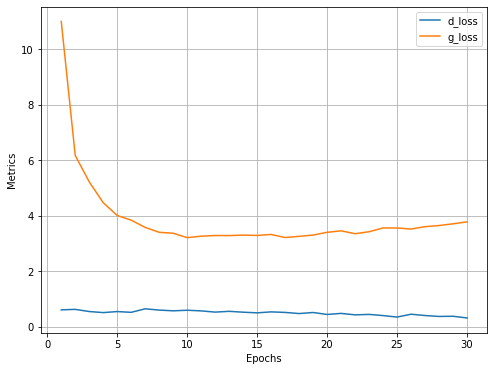

In [13]:
log = Report(30)
for epoch in range(30):
    N = len(dataloader)
    for i, images in enumerate(dataloader):
        real_data = images.to(device)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        fake_data = fake_data.detach()
        d_loss = discriminator_train_step(real_data, fake_data)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        g_loss = generator_train_step(fake_data)
        log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(), end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['d_loss','g_loss'])

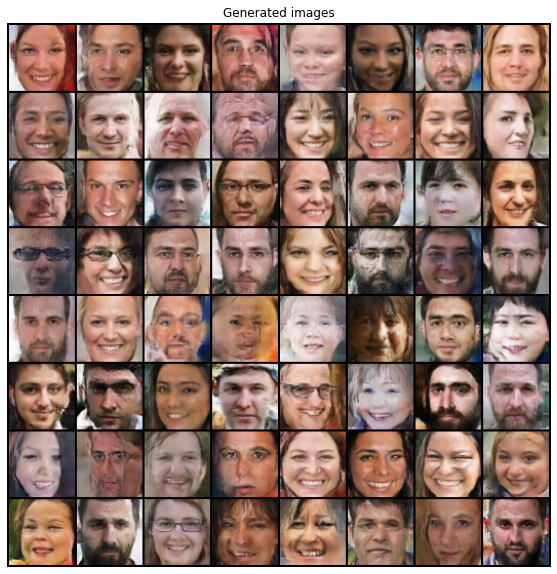

In [14]:
generator.eval()
noise = torch.randn(64, 100, 1, 1, device=device)
sample_images = generator(noise).detach().cpu()
grid = vutils.make_grid(sample_images,nrow=8,normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=10, \
title='Generated images')